In [1]:
import os
import requests
import pandas as pd
import json
import time
import random
from datetime import datetime, timedelta
import numpy as np 
import xml.etree.ElementTree as ET

import pymysql as mysql
import mysql.connector
import warnings
import matplotlib.pyplot as plt
import csv
from nltk.tokenize import word_tokenize

import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
from string import punctuation
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize  


#nltk.download('punkt')
#nltk.download('stopwords')


from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams

from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})


# mysql password
PASSWORD = "password"

import nbimporter
from Functions import process_text, add_sequential_index, process_label_text, remove_duplicates,classify_product_type, nan_info

# FDA Data

### API Request for Historical Text Documents

https://open.fda.gov/apis/other/historicaldocument/

In [2]:
# OpenFDA API endpoint for fetching historical documents
BASE_URL = 'https://api.fda.gov/other/historicaldocument.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Adjust the limit as needed
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(5 + 10 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    documents = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        print(f"Requesting data with params: {params}")  # Debugging statement
        print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            doc_type = item.get('doc_type', 'N/A')
            year = item.get('year', 'N/A')
            text = item.get('text', 'N/A')
            document = {'doc_type': doc_type, 'year': year, 'text': text}
            if document not in documents:
                documents.append(document)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

    return documents

# Fetch the data
documents = fetch_data(max_requests=1)

# Save the data to a CSV file
documents_df = pd.DataFrame(documents)
documents_df.head()

Requesting data with params: {'limit': 1000, 'skip': 0}
Response status code: 200


,doc_type,year,text
0,pr,2006,FDA NEWS RELEASE\nFOR IMMEDIATE RELEASE\n\nFeb...
1,pr,2006,FDA NEWS RELEASE\nFOR IMMEDIATE RELEASE\n\nFeb...
2,talk,1991,I FOOD _-AND DRUG ADMINISTRATION ‘ 'i\nU. S. D...
3,pr,1934,iNFORMATION FOR THE PRESS\n\nu 8. DEPARTMENT O...
4,pr,1975,\n\nU. S. DEPARTMENT OF HEALTH. EDUCATION. AN...


In [3]:
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_type  1000 non-null   object
 1   year      1000 non-null   int64 
 2   text      1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [4]:
# Save csv file to data library
#csv_file_path = 'DataLibrary/raw_documents.csv'
#documents_df.to_csv(csv_file_path, index=False)

# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_documents.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(documents, json_file, indent=4)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

### API Request for Adverse Events Data

https://open.fda.gov/apis/drug/event/

In [42]:
# OpenFDA API endpoint for fetching drug event data
BASE_URL = 'https://api.fda.gov/drug/event.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(5 + 10 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    events = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        print(f"Requesting data with params: {params}")  # Debugging statement
        print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            events.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

    return events

# Fetch the data
events = fetch_data(max_requests=2)

# Convert the data to a pandas DataFrame
events_df = pd.json_normalize(events)

# Display the first few rows of the DataFrame
events_df.head()

Requesting data with params: {'limit': 1000, 'skip': 0}
Response status code: 200
Requesting data with params: {'limit': 1000, 'skip': 1000}
Response status code: 200


,safetyreportid,transmissiondateformat,transmissiondate,serious,seriousnessdeath,receivedateformat,receivedate,receiptdateformat,receiptdate,fulfillexpeditecriteria,...,seriousnessother,occurcountry,patient.patientagegroup,seriousnesshospitalization,patient.summary.narrativeincludeclinical,seriousnesslifethreatening,patient.patientweight,primarysource.literaturereference,seriousnesscongenitalanomali,authoritynumb
0,5801206-7,102,20090109,1,1,102,20080707,102,20080625,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10003300,102,20141002,1,NaN,102,20140306,102,20140306,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10003301,102,20141002,1,NaN,102,20140228,102,20140228,2,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10003302,102,20141002,2,NaN,102,20140312,102,20140312,2,...,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10003304,102,20141212,2,NaN,102,20140312,102,20140424,2,...,NaN,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   safetyreportid                               2000 non-null   object 
 1   transmissiondateformat                       2000 non-null   object 
 2   transmissiondate                             2000 non-null   object 
 3   serious                                      2000 non-null   object 
 4   seriousnessdeath                             145 non-null    object 
 5   receivedateformat                            2000 non-null   object 
 6   receivedate                                  2000 non-null   object 
 7   receiptdateformat                            2000 non-null   object 
 8   receiptdate                                  2000 non-null   object 
 9   fulfillexpeditecriteria                      2000 non-null   object 
 10  

### Examine Variables of Interest

In [9]:
# 2 - Yes, 1 - No
events_df['fulfillexpeditecriteria'].value_counts()

fulfillexpeditecriteria
2    1131
1     869
Name: count, dtype: int64

In [10]:
# 5 - Consumer/NonHealth, 4 - Lawyer, 3 - Health Professional, 4 - Pharmacist, 5 - MD
events_df['primarysource.qualification'].value_counts()

primarysource.qualification
5    1084
1     412
3     288
4     151
2      57
Name: count, dtype: int64

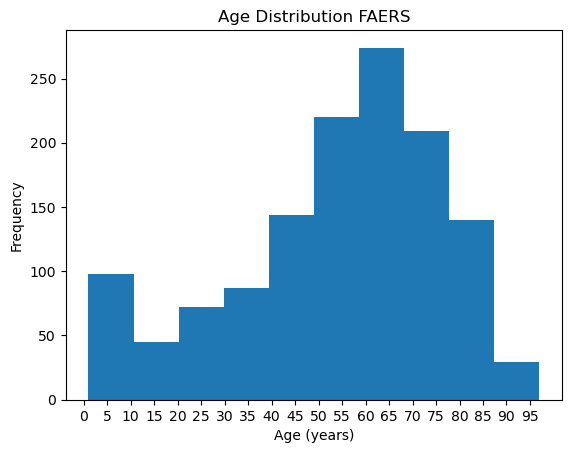

In [22]:
# Distribution of Age
plt.hist(events_df['patient.patientonsetage'].astype('float'))
ticks = np.arange(0, 100, 5)  # Customize this range as needed
plt.xticks(ticks)
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution FAERS')
plt.show()

In [23]:
# Ages come in different units, need to standardize to years
events_df['patient.patientonsetageunit'].value_counts()

patient.patientonsetageunit
801    1313
804       4
802       1
Name: count, dtype: int64

In [24]:
# Some reports have more than one version, retain most recent versions only
events_df['safetyreportversion'].value_counts()

safetyreportversion
1     1040
2      556
3      337
4       37
5       10
6        6
7        6
8        3
9        2
11       1
12       1
Name: count, dtype: int64

In [27]:
# Can see manufacturers where most reports were and duplicated
events_df['reportduplicate.duplicatesource'].value_counts()

reportduplicate.duplicatesource
GILEAD                  458
PFIZER                  320
MERCK                   175
INCYTE                  166
ABBVIE                  160
NOVARTIS                139
BAXTER                   82
GLAXOSMITHKLINE          75
TEVA                     51
BOEHRINGER INGELHEIM     47
BAYER                    45
SANDOZ                   32
CELGENE                  29
MYLAN                    29
JANSSEN                  20
LUNDBECK                 18
WATSON                   18
BRISTOL MYERS SQUIBB     15
AVENTIS                  11
GE HEALTHCARE            11
AMGEN                    11
ACTAVIS                   8
ASTRAZENECA               7
ALEXION                   7
ROCHE                     6
ACTELION                  6
EMD SERONO INC            6
ACORDA                    6
FOREST                    6
PURDUE                    4
VERTEX                    4
OTSUKA                    3
CUBIST                    3
ETHICON                   3
PHARMACYCLICS   

In [7]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_events.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(events, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_events.csv'
#events_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

### API Request for Drug Labels

https://open.fda.gov/apis/drug/label/

In [28]:
# OpenFDA API endpoint for fetching drug label data
BASE_URL = 'https://api.fda.gov/drug/label.json'

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(5 + 10 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    labels = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        response = requests.get(BASE_URL, params=params)
        print(f"Requesting data with params: {params}")  # Debugging statement
        print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            labels.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

    return labels

# Fetch the data
labels = fetch_data(max_requests=2)

# Convert the data to a pandas DataFrame
labels_df = pd.json_normalize(labels)

# Display the first few rows of the DataFrame
labels_df.head()

Requesting data with params: {'limit': 1000, 'skip': 0}
Response status code: 200
Requesting data with params: {'limit': 1000, 'skip': 1000}
Response status code: 200


,effective_time,inactive_ingredient,purpose,keep_out_of_reach_of_children,warnings,questions,spl_product_data_elements,version,dosage_and_administration,pregnancy_or_breast_feeding,...,components,intended_use_of_the_device,mechanism_of_action_table,general_precautions_table,drug_and_or_laboratory_test_interactions_table,accessories,ask_doctor_table,when_using_table,ask_doctor_or_pharmacist_table,do_not_use_table
0,20210902,[INACTIVE INGREDIENTS Sucrose],"[USES USES: Temporary Relief - Acne, Boils* * ...",[Keep this and all medication out of reach of ...,[WARNINGS This product is to be used for self-...,[QUESTIONS OR COMMENTS www.Rxhomeo.com | 1.888...,[SILICEA SILICEA SUCROSE SILICON DIOXIDE SILIC...,2,"[DOSAGE Adults- Take 4 or 6 Pellets by mouth, ...","[As with any drug, if you are pregnant, or nur...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20150109,"[INGREDIENTS: TALC, POLYMETHYL METHACRYLATE, V...",[Purpose Sunscreen],[Keep out of reach of children If product is s...,[Warnings For external use only.],NaN,[CHANTECAILLE PROTECTION NATURELLE BRONZE SPF ...,4,[Directions Protection Naturelle SPF 46 PA+++ ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230802,[INACTIVE INGREDIENTS Sucrose/Lactose],[USES To relieve the symptoms of itching.],[KEEP OUT OF REACH OF CHILDREN Keep this and a...,[STOP USE AND ASK DOCTOR If symptoms persist/w...,NaN,[Mezereum DAPHNE MEZEREUM BARK SUCROSE LACTOSE...,3,[DIRECTIONS Adults: Dissolve 3 to 5 under the ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230905,NaN,NaN,NaN,[WARNINGS NOT FOR INJECTION. Ofloxacin ophthal...,NaN,[Ofloxacin Ofloxacin OFLOXACIN OFLOXACIN Sodiu...,7,[DOSAGE AND ADMINISTRATION The recommended dos...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230403,NaN,NaN,NaN,NaN,NaN,[Naproxen Naproxen NAPROXEN NAPROXEN CROSCARME...,27,[2 DOSAGE AND ADMINISTRATION Use the lowest ef...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
pd.set_option('display.max_info_columns', 140)
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 140 columns):
 #    Column                                                            Non-Null Count  Dtype 
---   ------                                                            --------------  ----- 
 0    effective_time                                                    2000 non-null   object
 1    inactive_ingredient                                               1218 non-null   object
 2    purpose                                                           1190 non-null   object
 3    keep_out_of_reach_of_children                                     1186 non-null   object
 4    warnings                                                          1586 non-null   object
 5    questions                                                         659 non-null    object
 6    spl_product_data_elements                                         1999 non-null   object
 7    version                        

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: abuse, dtype: object

In [68]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/raw_labels.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(labels, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_labels.csv'
#labels_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# National Library of Medicine - Standardized Drug Names and Information (maybe not needed)

https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

### API Request for RxNorm

In [69]:
# Base URL for RxTerms API to get all drug names
#BASE_URL = 'https://rxnav.nlm.nih.gov/REST/RxTerms/rxcui'

# Function to pause execution to avoid overwhelming the server
#def pause_execution():
#    time.sleep(1 + 2 * random.random())

# Function to fetch data from the RxTerms API
#def fetch_data(max_requests):
#    drugs = []
#    start_rxcui = 1  # Starting RxCUI for the search
#    step = 500      # Step size to iterate through RxCUIs
#    request_count = 0  # Initialize request counter

#    while request_count < max_requests:
#        batch_drugs = []
#        for i in range(start_rxcui, start_rxcui + step):
#            url = f"{BASE_URL}/{i}/allinfo.json"
#            response = requests.get(url)

#            if response.status_code != 200:
#                print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
#                continue

#            if response.content.strip():  # Check if the response content is not empty
#                data = response.json()
#                properties = data.get('rxtermsProperties', {})

#                if properties:
#                    if properties.get('marketed', '').lower() == 'true':
#                        properties['rxcui'] = i
#                        batch_drugs.append(properties)

#        drugs.extend(batch_drugs)  # Add the batch results to the main list
#        print(f"Processed batch starting with RxCUI: {start_rxcui}")  # Debugging statement for each batch

        # Update the start_rxcui for the next batch
 #       start_rxcui += step
#      request_count += 1  # Increment request counter

        # Break condition to stop if no more data in the batch
#        if not batch_drugs:
#            break

#        pause_execution()

#    return drugs

# Fetch the data
#drugs = fetch_data(max_requests=1)

# Convert the data to a pandas DataFrame
#drugs_df = pd.DataFrame(drugs)

# Display the first few rows of the DataFrame
#drugs_df.head()

In [70]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/rxterms_drugs.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(drugs, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/rxterms_drugs.csv'
#drugs_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# ADReCS Database for Standardized Drug and Side Effect Labeling

In [ ]:
# load in static files, store in github folder or add to database if too large

# Medicaid Drug Prices - 2024 Report - API 

https://data.medicaid.gov/dataset/99315a95-37ac-4eee-946a-3c523b4c481e#data-table

In [30]:
# Base URL for the Medicaid API for NADAC data
BASE_URL = 'https://data.medicaid.gov/api/1/datastore/sql'

# Initial SQL query to fetch data with a limit of 500 and initial offset 0
# Queries 2024 Database
query_template = '[SELECT * FROM f3b5cf6b-07cc-5f75-8d7b-0a1090b3f7e9][LIMIT 500 OFFSET {}]'

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    # Pause execution for a random time between 1 and 3 seconds to avoid hitting the server too hard
    time.sleep(1 + 2 * random.random())

# Function to fetch data from the Medicaid API in batches
def fetch_nadac_data():
    all_data = []  # Initialize an empty list to store all fetched data
    offset = 0  # Starting offset for pagination
    max_requests = 2  # Maximum number of requests to fetch 1000 records
    
    for _ in range(max_requests):  # Loop to fetch data in batches
        # Modify the query to include the current offset for pagination
        query = query_template.format(offset)
        params = {'query': query}  # Set the parameters for the API request

        response = requests.get(BASE_URL, params=params)  # Send the request to the API
        print(f"Requesting data with offset: {offset}")  # Debugging statement to show current offset
        print(f"Response status code: {response.status_code}")  # Debugging statement to show response status

        if response.status_code != 200:  # Check if the request was unsuccessful
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement for error status
            try:
                error_details = response.json()
                print(f"Error message: {error_details.get('message', 'No message provided')}")  # Print the error message
                print(f"Error details: {error_details.get('data', 'No additional data provided')}")  # Print additional error details
            except ValueError:
                print("Failed to decode JSON error response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error

        try:
            data = response.json()  # Parse the response JSON
            #print(f"Raw response data: {data}")  # Debugging statement to show raw response data
            
            if not isinstance(data, list):  # Check if the response is an array
                print("Expected a list but got a different structure.")
                break

            if not data:  # Check if the list is empty
                print("No more results found.")  # Debugging statement to indicate no more data
                break  # Exit the loop if no more data is found

            all_data.extend(data)  # Append the fetched data to the main list
            offset += len(data)  # Increment the offset by the number of records fetched
            print(f"Fetched {len(data)} records. Total so far: {len(all_data)}")  # Debugging statement to show fetched data count
        except ValueError:  # Handle any JSON decoding errors
            print("Failed to decode JSON response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error decoding JSON
        
        pause_execution()  # Pause before the next request to avoid overwhelming the server

    return all_data  # Return the collected data

# Fetch the data
prices = fetch_nadac_data()

# Convert the data to a pandas DataFrame
prices_df = pd.DataFrame(prices)

# Display the first few rows of the DataFrame
prices_df.head()
print(f"Total records fetched: {len(prices_df)}")  # Debugging statement

Requesting data with offset: 0
Response status code: 200
Fetched 500 records. Total so far: 500
Requesting data with offset: 500
Response status code: 200
Fetched 500 records. Total so far: 1000
Total records fetched: 1000


In [31]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   NDC Description                            1000 non-null   object
 1   NDC                                        1000 non-null   object
 2   NADAC_Per_Unit                             1000 non-null   object
 3   Effective Date                             1000 non-null   object
 4   Pricing_Unit                               1000 non-null   object
 5   Pharmacy_Type_Indicator                    1000 non-null   object
 6   OTC                                        1000 non-null   object
 7   Explanation_Code                           1000 non-null   object
 8   Classification_for_Rate_Setting            1000 non-null   object
 9   Corresponding_Generic_Drug_NADAC_Per_Unit  1000 non-null   object
 10  Corresponding_Generic_Drug_Effective_

In [73]:
prices_df.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
0,12HR NASAL DECONGEST ER 120 MG,24385005452,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
1,12HR NASAL DECONGEST ER 120 MG,70000047501,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
2,24H NASAL ALLERGY 55 MCG SPRAY,46122038576,0.78326,2022-12-21,ML,C/I,Y,"1, 5",G,,,2023-01-04
3,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036201,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
4,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036202,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04


# Select Variables of Interest from Datasets

In [43]:
#documents_df = pd.read_csv('DataLibrary/raw_documents.csv')
documents_table = pd.DataFrame(documents_df, 
                               columns = ["doc_type",  # pr: press release, talk: speech  
                                          "year", 
                                          "text"])


#events_df = pd.read_csv('DataLibrary/raw_events.csv.csv')
events_table = pd.DataFrame(events_df, 
                            columns = ["safetyreportid", #case report number
                                        "transmissiondate", # date the record was created
                                        "serious", # seriousness - 1 = result in death, lifethreatening,hospital,etc. 2 = not in the above
                                        "fulfillexpeditecriteria",  # 1 - Yes, 2 - No
                                        "primarysource.qualification",  # 1-MD, 2-Pharmacist, 3-Health Prof, 4-Lawyer, 5-Consumer/NonHealth
                                        "safetyreportversion",  # Indicates updated reports, with 1 being first, and increasing numbers as new 
                                        "companynumb",  # Company making report
                                        #"seriousnessdeath", # 1 = death, redundant with serious
                                        #  "receivedateformat", #always YYYYMMDD
                                        #  "receivedate", #date report received by FDA
                                        "primarysource.reportercountry", # country of the reporter of this event
                                        "patient.patientonsetage", # age of patient when event occured
                                        "patient.patientonsetageunit",  # 801: Y, 802: M, 803: W, 804: D, 805: H 
                                        "patient.patientsex", # sex of patient. 0=unknown, 1=male, 2=female
                                        "patient.reaction", # Dictionary list - expanded as seperate table
                                        "patient.drug", # Dictionary list - expanded as separate table
                                        # "patient.patientagegroup", #1 = neonate, 2 = infant, 3=child, 4=adolescent, 5=adult, 6=elderly
                                        # "patient.patientweight", # weight in kg
                                        # "seriousnesscongentialanomali", # 1 if congenital anomaly (fetal abnormality),absent otherwise
                                        # "authoritynumb", #regulatory authority case #
                                        # "reportduplicate"
                                      ])

#labels_df = pd.read_csv('')

labels_table = pd.DataFrame(labels_df, 
                            columns = ["effective_time",
                                        #"inactive_ingredient",  # Included in spl_product_data_elements
                                       "purpose",
                                       "warnings",  # Combine text with contraindications and precautions
                                        #"questions",  # Too much missing data
                                       "spl_product_data_elements",  # Contains both active and inactive ingredients
                                        #"version",  # Label version, not needed since ndc code captures this information
                                        #"package_label_principal_display_panel",  # Package label text, redundant information
                                        #"active_ingredient",  # Included in spl_product_data_elements
                                        "openfda.brand_name",  # Combine into list with generic
                                        "openfda.generic_name",  # Combine into list with brand
                                        "openfda.manufacturer_name",  # Company that produces the drug
                                        "openfda.product_type",  # Denotes whether OTC and prescription, and human or animal
                                        "openfda.substance_name",  # Combine with brand and generic
                                        "openfda.product_ndc",  # Do NOT tokenize, NDC Product code, use as database key, already a list
                                        #"openfda.package_ndc",  # Product NDC code plus one extra number for package type, Redundant
                                        "openfda.rxcui",  # Do NOT tokenize, normed drug code number, retain for database keys
                                        "contraindications",  # Combine with warnings and precautions
                                        "precautions"  # Combine with warnings and contraindications
                                        ])

#drugs_table = pd.read_csv('')

prices_table = pd.DataFrame(prices_df, 
                            columns = [#"NDC Description",  # Identifies the drug name/dosage, Redundant Information with labels_table
                                       "NDC",  # 11 character FDA code, Do NOT Tokenize, database key
                                       "NADAC_Per_Unit",  #  The National Average Drug Acquisition Cost per unit, do NOT tokenize
                                       "Effective Date",  # The effective date of the NADAC Per Unit cost
                                        #"Pricing_Unit",  # Pricing unit for NDC ('ML', 'GM 'or 'EA'), Not necessary, just use price
                                        #"Pharmacy_Type_Indicator",  # 'C/I' data from Chain/Independent pharmacies, does not provide helpful info
                                        #"OTC",  # Indicates whether NDC is over-the-counter (OTC), redundant with labels_table
                                        #"Explanation Code",  # NADAC Calculation Method, not necessary for this project, too much missing data
                                                                       # Code 1: Inform from most recent survey.
                                                                       # Code 2: Cost within ± 2%, carried forward from previous
                                                                       # Code 3: Published pricing, or help desk inquiry
                                                                       # Code 4: Carried forward from previous year
                                                                       # Code 5: Based on package size.
                                                                       # Code 6: CMS Covered Outpatient Drug Product File drug category 
                                        "Classification_for_Rate_Setting",  # B: brand, 
                                                                            # G: generic
                                                                            # B-ANDA: brand under ANDA
                                                                            # B-BIO: biosimilar brand  
                                        "Corresponding_Generic_Drug_NADAC_Per_Unit",
                                        "Corresponding_Generic_Drug_Effective_Date"
                                        #"As of Date"
                                      ])
                                            



# Preprocess Documents Table

In [33]:
start_time = time.time()

documents_table = pd.DataFrame(documents_df, columns=["doc_type", "year", "text"])

documents_table = add_sequential_index(documents_table,'doc_id')

documents_table.info()

print(documents_table['doc_type'].unique())

documents_table['text_processed'] = documents_table['text'].apply(lambda x: process_text(x))

end_time = time.time()

duration = end_time - start_time

print("Time taken for", len(documents_table), "records: ", round(duration,2), " seconds")

documents_table.drop(columns=['text'], inplace=True)

documents_table.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_id    1000 non-null   int64 
 1   doc_type  1000 non-null   object
 2   year      1000 non-null   int64 
 3   text      1000 non-null   object
dtypes: int64(2), object(2)
memory usage: 31.4+ KB
['pr' 'talk']
Time taken for 1000 records:  12.0  seconds


,doc_id,doc_type,year,text_processed
0,1,pr,2006,"[fda, news, release, immediate, release, febru..."
1,2,pr,2006,"[fda, news, release, immediate, release, febru..."
2,3,talk,1991,"[food, drug, administration, dc, partmcnt, hea..."
3,4,pr,1934,"[information, press, u, 8, department, agricul..."
4,5,pr,1975,"[department, health, education, welfare, food,..."


# PreProcess Events Table

In [44]:
events_table.head()

# Add an event ID
events_table = add_sequential_index(events_table,'event_id')

# Check for safety report # duplicates
duplicates = events_table.duplicated(subset=['safetyreportid']).sum()

print("Duplicates: ", duplicates) 

# Standardize date format
events_table['transmissiondate'] = pd.to_datetime(events_table['transmissiondate'], format='%Y%m%d')

# Make variable numeric
events_table['serious'] = events_table['serious'].astype(int)
# Save 1 as death, life threatening, hospitalization, disability, congenital anomaly, or serious condition, 0 as not that
events_table['serious'] = events_table['serious'].replace({1: 0, 2: 1})


# Fill null values with 0 to make binary column 
#events_table['seriousnessdeath'] = events_table['seriousnessdeath'].fillna(0)

# Rename some columns
events_table = events_table.rename(columns={
    'primarysource.reportercountry': 'country',
    'patient.patientsex': 'sex',
    'patient.reaction': 'reaction',
    'patient.drug': 'drug'
})

# Value counts of sex
sex_value_counts = events_table['sex'].value_counts()
print(sex_value_counts)

#For sex, 0=unknown, 1=male, 2=female. fill missing values with 0.
events_table['sex'] = events_table['sex'].fillna(0)


events_table.info()

events_table.head()

Duplicates:  0
sex
2    1184
1     618
0     186
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   event_id                     2000 non-null   int64         
 1   safetyreportid               2000 non-null   object        
 2   transmissiondate             2000 non-null   datetime64[ns]
 3   serious                      2000 non-null   int32         
 4   fulfillexpeditecriteria      2000 non-null   object        
 5   primarysource.qualification  1992 non-null   object        
 6   safetyreportversion          1999 non-null   object        
 7   companynumb                  2000 non-null   object        
 8   country                      2000 non-null   object        
 9   patient.patientonsetage      1318 non-null   object        
 10  patient.patientonsetageunit  1318

,event_id,safetyreportid,transmissiondate,serious,fulfillexpeditecriteria,primarysource.qualification,safetyreportversion,companynumb,country,patient.patientonsetage,patient.patientonsetageunit,sex,reaction,drug
0,1,5801206-7,2009-01-09,0,1,3,NaN,JACAN16471,CANADA,26,801,1,[{'reactionmeddrapt': 'DRUG ADMINISTRATION ERR...,"[{'drugcharacterization': '1', 'medicinalprodu..."
1,2,10003300,2014-10-02,0,2,5,1,1289378,US,77,801,2,"[{'reactionmeddraversionpt': '17.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu..."
2,3,10003301,2014-10-02,0,2,5,1,US-JNJFOC-20130719067,US,NaN,NaN,2,"[{'reactionmeddraversionpt': '17.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu..."
3,4,10003302,2014-10-02,1,2,5,1,US-PFIZER INC-2014068976,US,NaN,NaN,1,"[{'reactionmeddraversionpt': '17.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu..."
4,5,10003304,2014-12-12,1,2,1,2,US-PFIZER INC-2014063856,US,NaN,NaN,2,"[{'reactionmeddraversionpt': '17.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu..."


### Examine Variables in Reaction Nested Dataframe - Multiple Reaction Reports for Each Symptom for Each Person

In [79]:
test_record = events_table['reaction'].loc[events_table['event_id'] == 2000]
# Patient Reaction is an array containing:
    # reactionmeddrapt: Patient reaction, as a MedDRA term. 
    # reactionmeddraversionpt: The version of MedDRA from which the term in reactionmeddrapt is drawn.
    # reactionoutcome: Outcome of the reaction in reactionmeddrapt at the time of last observation.
        # 1= Recovered/resolved, 2=recovering/resolving, 3 = Not recovered/not resolved, 4=Recovered/resolved with consequent health issues
        # 5 = fatal, 6 = Unknown

# First, want to individualzie these fields. Will actually save these as a NEW table, called PatientReactions

In [80]:
# Set pandas option to display full content of columns
pd.set_option('display.max_colwidth', None)
print(test_record)

1999    [{'reactionmeddraversionpt': '17.0', 'reactionmeddrapt': 'Tremor', 'reactionoutcome': '3'}, {'reactionmeddraversionpt': '17.0', 'reactionmeddrapt': 'Muscle disorder', 'reactionoutcome': '3'}, {'reactionmeddraversionpt': '17.0', 'reactionmeddrapt': 'Injection site erythema', 'reactionoutcome': '3'}]
Name: reaction, dtype: object


### Make new table for PatientDrugs - nested dataframe

In [45]:
expanded_patient_drugs = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_drugs.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_drugs_table = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]

patient_drugs_table.tail()

,event_id,drugcharacterization,medicinalproduct,drugauthorizationnumb,drugadministrationroute,drugindication,drugbatchnumb,drugstructuredosagenumb,drugstructuredosageunit,drugdosagetext,...,drugdosageform,openfda.pharm_class_pe,activesubstance.activesubstancename,drugenddateformat,drugenddate,drugseparatedosagenumb,drugintervaldosageunitnumb,drugintervaldosagedefinition,drugcumulativedosagenumb,drugcumulativedosageunit
5987,1998,1,ENDOXAN-1G,012142,065,PLASMA CELL MYELOMA,NaN,NaN,NaN,3 TO 4 G/M2 ON DAY 0,...,POWDER FOR SOLUTION FOR INJECTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5988,1998,1,GRANULOCYTE COLONY-STIMULATING FACTOR NOS,NaN,065,PLASMA CELL MYELOMA,NaN,5,008,STARTING ON DAY 5 AND ADMINISTER UNTIL END OF ...,...,NaN,NaN,NaN,NaN,NaN,1,1,804,NaN,NaN
5989,1998,1,GRANULOCYTE COLONY-STIMULATING FACTOR NOS,NaN,065,NaN,NaN,NaN,NaN,12 HOURS LATER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5990,1999,1,PRADAXA,022512,065,ATRIAL FIBRILLATION,NaN,150,003,300 MG,...,CAPSULE,NaN,NaN,NaN,NaN,2,1,804,NaN,NaN
5991,2000,1,REBIF,103780,NaN,PRODUCT USED FOR UNKNOWN INDICATION,AU007689,44,004,NaN,...,INJECTION,NaN,NaN,NaN,NaN,3,1,803,NaN,NaN


### Make new table for PatientReactions

In [49]:
expanded_patient_reaction = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['reaction']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_reaction.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_reactions_table = pd.concat(expanded_patient_reaction, ignore_index=True)
patient_reactions_table = patient_reactions_table[['event_id'] + [col for col in patient_reactions_table.columns if col != 'event_id']]
patient_reactions_table.tail()

,event_id,reactionmeddrapt,reactionmeddraversionpt,reactionoutcome
5222,1998,Hypokalaemia,17.0,6
5223,1999,Lower gastrointestinal haemorrhage,17.0,6
5224,2000,Tremor,17.0,3
5225,2000,Muscle disorder,17.0,3
5226,2000,Injection site erythema,17.0,3


### PreProcess Patient Drugs Table

In [50]:
patient_drugs_table

patient_drugs_table = add_sequential_index(patient_drugs_table,'patient_drug_id')

patient_drugs_table.head()

patient_drugs_table.columns

Index(['patient_drug_id', 'event_id', 'drugcharacterization',
       'medicinalproduct', 'drugauthorizationnumb', 'drugadministrationroute',
       'drugindication', 'drugbatchnumb', 'drugstructuredosagenumb',
       'drugstructuredosageunit', 'drugdosagetext', 'drugstartdateformat',
       'drugstartdate', 'drugrecurreadministration', 'drugadditional',
       'openfda.application_number', 'openfda.brand_name',
       'openfda.generic_name', 'openfda.manufacturer_name',
       'openfda.product_ndc', 'openfda.product_type', 'openfda.route',
       'openfda.substance_name', 'openfda.rxcui', 'openfda.spl_id',
       'openfda.spl_set_id', 'openfda.package_ndc', 'openfda.nui',
       'openfda.pharm_class_moa', 'openfda.pharm_class_cs',
       'openfda.pharm_class_epc', 'openfda.unii', 'actiondrug',
       'drugdosageform', 'openfda.pharm_class_pe',
       'activesubstance.activesubstancename', 'drugenddateformat',
       'drugenddate', 'drugseparatedosagenumb', 'drugintervaldosageunitnumb',

In [53]:
patient_drugs_table = pd.DataFrame(patient_drugs_table, 
                               columns = [
                                'patient_drug_id',  # Identifier for patient drug
                                'event_id',  # Identifier for the event
                                'drugcharacterization',  # Level of detail for the drug in the event report
                                'medicinalproduct',  # Name of the drug
                                # 'drugauthorizationnumb',  # Marketing authorization number of the drug
                                # 'drugadministrationroute',  # Route of administration for the drug
                                'drugindication',  # Indication for use of the drug
                                # 'drugbatchnumb',  # Batch number for the drug
                                # 'drugstructuredosagenumb',  # Structured dosage number of the drug
                                # 'drugstructuredosageunit',  # Unit of structured dosage for the drug
                                # 'drugdosagetext',  # Textual description of the dosage for the drug
                                # 'drugstartdateformat',  # Date format for the start date of drug administration
                                # 'drugstartdate',  # Start date of drug administration
                                #'drugrecurreadministration',  # Indicator for recurring drug administration
                                # 'drugadditional',  # Additional details about the drug
                                # 'openfda.application_number',  # FDA application number for the drug
                                # 'openfda.brand_name',  # Brand name for the drug
                                'openfda.generic_name',  # Generic name for the drug
                                'openfda.manufacturer_name',  # Manufacturer name for the drug
                                #'openfda.product_ndc',  # NDC (National Drug Code) number for the drug product
                                'openfda.product_type',  # Type of drug product (e.g., HUMAN PRESCRIPTION DRUG)
                                # 'openfda.route',  # Route of administration for the drug
                                # 'openfda.substance_name',  # Substance name associated with the drug
                                'openfda.rxcui',  # RxNorm Concept Unique Identifier (RxCUI) for the drug
                                # 'openfda.spl_id',  # Structured Product Labeling (SPL) ID for the drug
                                # 'openfda.spl_set_id',  # SPL Set ID for the drug
                                # 'openfda.package_ndc',  # NDC (National Drug Code) number for the drug package
                                # 'openfda.nui',  # NUI (National Uniform Identifier) for the drug
                                # 'openfda.pharm_class_moa',  # Pharmacological class (Mechanism of Action) for the drug
                                # 'openfda.pharm_class_cs',  # Chemical structure class for the drug
                                # 'openfda.pharm_class_epc',  # Pharmacological class (EPC) for the drug
                                'openfda.unii',  # Unique Ingredient Identifier (UNII) for the drug substance
                                # 'actiondrug',  # Action taken with the drug
                                # 'drugdosageform',  # Dosage form of the drug
                                # 'openfda.pharm_class_pe',  # Pharmacological class (Physiologic Effect) for the drug
                                # 'activesubstance.activesubstancename',  # Name of the active substance in the drug
                                # 'drugenddateformat',  # Date format for the end date of drug administration
                                # 'drugenddate',  # End date of drug administration
                                #'drugseparatedosagenumb',  # Separated dosage number for the drug
                                # 'drugintervaldosageunitnumb',  # Interval dosage unit number for the drug
                                # 'drugintervaldosagedefinition',  # Definition of interval dosage for the drug
                                # 'drugcumulativedosagenumb',  # Cumulative dosage number for the drug
                                # 'drugcumulativedosageunit'  # Unit of cumulative dosage for the drug
                            ])


In [54]:
patient_drugs_table.head()

,patient_drug_id,event_id,drugcharacterization,medicinalproduct,drugindication,openfda.generic_name,openfda.manufacturer_name,openfda.product_type,openfda.rxcui,openfda.unii
0,1,1,1,DURAGESIC-100,DRUG ABUSE,NaN,NaN,NaN,NaN,NaN
1,2,2,1,BONIVA,OSTEOPOROSIS,NaN,NaN,NaN,NaN,NaN
2,3,3,1,IBUPROFEN,PRODUCT USED FOR UNKNOWN INDICATION,"[IBUPROFEN, IBUPROFEN CAPSULES 200 MG, IBUPROF...","[DOLGENCORP INC, American Sales Company, Famil...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[310964, 310965, 197803, 201126, 204442, 31096...",[WK2XYI10QM]
3,4,4,1,LYRICA,NaN,[PREGABALIN],"[Parke-Davis Div of Pfizer Inc, Viatris Specia...",[HUMAN PRESCRIPTION DRUG],"[483438, 483440, 483442, 483444, 483446, 48344...",[55JG375S6M]
4,5,5,1,DOXYCYCLINE HYCLATE,NaN,"[DOXYCYCLINE HYCLATE, DOXYCYCLINE, DOXYCLYCLIN...","[Mayne Pharma Commercial LLC, Actavis Pharma, ...",[HUMAN PRESCRIPTION DRUG],"[1653433, 2122343, 1650143, 1652674, 283535, 4...","[19XTS3T51U, N12000U13O, 8ZL07I20SB]"


#### Examining Variables of Interest
* Drugcharacterization: 1-suspect(drug primary cause), 2-concomitant(drug taken with primary cause), 3-interation(drug interact with primary cause)
* Medicinalproduct: generic or brand name
* Drugindication: official drug purpose
* openfda.rxcui : Rx cui code
* openfda.unii : unique ingredient identifier

In [47]:
patient_drugs_table['drugcharacterization'].value_counts()

drugcharacterization
1    3551
2    2427
3      14
Name: count, dtype: int64

In [55]:
patient_drugs_table_nan_info = nan_info(patient_drugs_table)
patient_drugs_table_nan_info

,column_name,null_count,null_proportion
0,patient_drug_id,0,0.000000
1,event_id,0,0.000000
2,drugcharacterization,0,0.000000
3,medicinalproduct,0,0.000000
4,drugindication,2248,37.516689
5,openfda.generic_name,1742,29.072096
6,openfda.manufacturer_name,1742,29.072096
7,openfda.product_type,1742,29.072096
8,openfda.rxcui,1864,31.108144
9,openfda.unii,1834,30.607477


### Processing Text Data

In [57]:
# Define text columns
object_columns = patient_drugs_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['openfda.unii', 'openfda.rxcui'], errors='ignore')
patient_drugs_table[object_columns] = patient_drugs_table[object_columns].astype(str)

# Apply text processing to the selected text columns and add new processed columns to dataframe
for col in object_columns:
    new_col_name = col + '_processed'
    patient_drugs_table[new_col_name] = patient_drugs_table[col].apply(process_label_text)

In [58]:
patient_drugs_table.head()

,patient_drug_id,event_id,drugcharacterization,medicinalproduct,drugindication,openfda.generic_name,openfda.manufacturer_name,openfda.product_type,openfda.rxcui,openfda.unii,drugcharacterization_processed,medicinalproduct_processed,drugindication_processed,openfda.generic_name_processed,openfda.manufacturer_name_processed,openfda.product_type_processed
0,1,1,1,DURAGESIC-100,DRUG ABUSE,nan,nan,nan,NaN,NaN,[1],"[duragesic, 100]","[drug, abuse]",[nan],[nan],[nan]
1,2,2,1,BONIVA,OSTEOPOROSIS,nan,nan,nan,NaN,NaN,[1],[boniva],[osteoporosis],[nan],[nan],[nan]
2,3,3,1,IBUPROFEN,PRODUCT USED FOR UNKNOWN INDICATION,"['IBUPROFEN', 'IBUPROFEN CAPSULES 200 MG', 'IB...","['DOLGENCORP INC', 'American Sales Company', '...","['HUMAN OTC DRUG', 'HUMAN PRESCRIPTION DRUG']","[310964, 310965, 197803, 201126, 204442, 31096...",[WK2XYI10QM],[1],[ibuprofen],"[product, used, unknown, indication]","[ibuprofen, capsule, 200, mg, tablet, usp, 200...","[dolgencorp, inc, american, sale, company, fam...","[human, otc, drug, prescription]"
3,4,4,1,LYRICA,nan,['PREGABALIN'],"['Parke-Davis Div of Pfizer Inc', 'Viatris Spe...",['HUMAN PRESCRIPTION DRUG'],"[483438, 483440, 483442, 483444, 483446, 48344...",[55JG375S6M],[1],[lyrica],[nan],[pregabalin],"[parke, davis, div, pfizer, inc, viatris, spec...","[human, prescription, drug]"
4,5,5,1,DOXYCYCLINE HYCLATE,nan,"['DOXYCYCLINE HYCLATE', 'DOXYCYCLINE', 'DOXYCL...","['Mayne Pharma Commercial LLC', 'Actavis Pharm...",['HUMAN PRESCRIPTION DRUG'],"[1653433, 2122343, 1650143, 1652674, 283535, 4...","[19XTS3T51U, N12000U13O, 8ZL07I20SB]",[1],"[doxycycline, hyclate]",[nan],"[doxycycline, hyclate, doxyclycline]","[mayne, pharma, commercial, llc, actavis, inc,...","[human, prescription, drug]"


In [59]:
patient_drugs_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   patient_drug_id                      5992 non-null   int64 
 1   event_id                             5992 non-null   int64 
 2   drugcharacterization                 5992 non-null   object
 3   medicinalproduct                     5992 non-null   object
 4   drugindication                       5992 non-null   object
 5   openfda.generic_name                 5992 non-null   object
 6   openfda.manufacturer_name            5992 non-null   object
 7   openfda.product_type                 5992 non-null   object
 8   openfda.rxcui                        4128 non-null   object
 9   openfda.unii                         4158 non-null   object
 10  drugcharacterization_processed       5992 non-null   object
 11  medicinalproduct_processed           5992 n

#### Final list of features for Patient Drugs Table

In [60]:
patient_drugs_table = patient_drugs_table[['patient_drug_id',
                                          'event_id',
                                          'drugcharacterization',
                                          'medicinalproduct_processed',
                                          'openfda.generic_name_processed',
                                          'openfda.manufacturer_name_processed',
                                          'openfda.product_type_processed',
                                          'openfda.rxcui',
                                          'openfda.unii'
                                          ]]

### PreProcess Patient Reactions Table

In [61]:
patient_reactions_table

patient_reactions_table = add_sequential_index(patient_reactions_table,'patient_reaction_id')

patient_reactions_table.info()

patient_reactions_table = patient_reactions_table.rename(columns={
    'reactionmeddrapt': 'reaction',
    'reactionmeddraversionpt': 'version_medDRA',
    'reactionoutcome': 'outcome'
})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5227 entries, 0 to 5226
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_reaction_id      5227 non-null   int64 
 1   event_id                 5227 non-null   int64 
 2   reactionmeddrapt         5227 non-null   object
 3   reactionmeddraversionpt  5225 non-null   object
 4   reactionoutcome          5069 non-null   object
dtypes: int64(2), object(3)
memory usage: 204.3+ KB


In [62]:
#map outcomes to text categories
outcome_mapping = {
    1: 'Recovered/resolved',
    2: 'Recovering/resolving',
    3: 'Not recovered/not resolved',
    4: 'Recovered/resolved with consequent health issues',
    5: 'Fatal',
    6: 'Unknown'
}

#patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna(0).astype(int).map(outcome_mapping)

patient_reactions_table.tail()

,patient_reaction_id,event_id,reaction,version_medDRA,outcome
5222,5223,1998,Hypokalaemia,17.0,6
5223,5224,1999,Lower gastrointestinal haemorrhage,17.0,6
5224,5225,2000,Tremor,17.0,3
5225,5226,2000,Muscle disorder,17.0,3
5226,5227,2000,Injection site erythema,17.0,3


### Tokenize reactions

In [69]:
patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)

In [70]:
patient_reactions_table = patient_reactions_table.drop('reaction', axis = 1)

In [81]:
patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info

#fill the missing values in the outcome table with 'Unknown'
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna('Unknown')

patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info


,column_name,null_count,null_proportion
0,patient_reaction_id,0,0.000000
1,event_id,0,0.000000
2,version_medDRA,2,0.038263
3,outcome,0,0.000000
4,reaction_processed,0,0.000000


## Combine all Adverse Events Sub-Dataframes on event_id

In [82]:
# Drop 'drug' and 'reaction' from main event table
events_table = events_table.drop(['drug', 'reaction'], axis = 1)

In [88]:
# Merge events and drugs
events_join = pd.merge(events_table, patient_drugs_table, on='event_id', how='outer')

In [89]:
# Merge the result with reactions
events_join = pd.merge(events_join, patient_reactions_table, on='event_id', how='outer')
# View combined dataframe

In [90]:
# View combined dataframe
events_join.info()
events_join.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21324 entries, 0 to 21323
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   event_id                             21324 non-null  int64         
 1   safetyreportid                       21324 non-null  object        
 2   transmissiondate                     21324 non-null  datetime64[ns]
 3   serious                              21324 non-null  int32         
 4   fulfillexpeditecriteria              21324 non-null  object        
 5   primarysource.qualification          21072 non-null  object        
 6   safetyreportversion                  21322 non-null  object        
 7   companynumb                          21324 non-null  object        
 8   country                              21324 non-null  object        
 9   patient.patientonsetage              15988 non-null  object        
 10  patient.pa

,event_id,safetyreportid,transmissiondate,serious,fulfillexpeditecriteria,primarysource.qualification,safetyreportversion,companynumb,country,patient.patientonsetage,...,medicinalproduct_processed,openfda.generic_name_processed,openfda.manufacturer_name_processed,openfda.product_type_processed,openfda.rxcui,openfda.unii,patient_reaction_id,version_medDRA,outcome,reaction_processed
0,1,5801206-7,2009-01-09,0,1,3,NaN,JACAN16471,CANADA,26,...,"[duragesic, 100]",[nan],[nan],[nan],NaN,NaN,1,NaN,Unknown,"[drug, administration, error]"
1,1,5801206-7,2009-01-09,0,1,3,NaN,JACAN16471,CANADA,26,...,"[duragesic, 100]",[nan],[nan],[nan],NaN,NaN,2,NaN,Unknown,[overdose]
2,2,10003300,2014-10-02,0,2,5,1,1289378,US,77,...,[boniva],[nan],[nan],[nan],NaN,NaN,3,17.0,Unknown,[vomiting]
3,2,10003300,2014-10-02,0,2,5,1,1289378,US,77,...,[boniva],[nan],[nan],[nan],NaN,NaN,4,17.0,Unknown,[diarrhoea]
4,2,10003300,2014-10-02,0,2,5,1,1289378,US,77,...,[boniva],[nan],[nan],[nan],NaN,NaN,5,17.0,Unknown,[arthralgia]


## Filter Adverse Events Data to Find Quality Reports

In [ ]:
events_join = pd.DataFrame(events_join)
events_join.shape()

In [ ]:
# No consumer or lawyer reports, only healthcare professionals
events_join = events_join[~events_join['primarysourcequalification'].isin([4, 5])]
events_join.shape()

In [ ]:
# Keep only primary drug suspects
events_join = events_join.loc[events_join['drugcharacterization'] == 1]
events_join.shape()

In [ ]:
# Keep latest version of reports only
# Group by report_id and get the index of the maximum safetyreportversion for each group
# Filter the DataFrame to keep only the rows with the latest version of each report
events_join = events_join.loc[events_join.groupby('event_id')['safetyreportversion'].idxmax()]
events_join.shape()

In [ ]:
# Make sure latest report numbers are retained
events_join['safetyreportversion'].head(50)

In [ ]:
# Drop unknown reaction outcomes
events_join = events_join.loc[events_join['outcome'] != 6]
events_join.shape()

In [ ]:
events_join.info()

In [ ]:
events_join.head()

# PreProcess Labels Table

In [87]:
labels_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   effective_time             2000 non-null   object
 1   purpose                    1190 non-null   object
 2   warnings                   1586 non-null   object
 3   spl_product_data_elements  1999 non-null   object
 4   openfda.brand_name         986 non-null    object
 5   openfda.generic_name       986 non-null    object
 6   openfda.manufacturer_name  986 non-null    object
 7   openfda.product_type       986 non-null    object
 8   openfda.substance_name     976 non-null    object
 9   openfda.product_ndc        986 non-null    object
 10  openfda.rxcui              733 non-null    object
 11  contraindications          752 non-null    object
 12  precautions                421 non-null    object
dtypes: object(13)
memory usage: 203.2+ KB


In [88]:
# Define text columns
object_columns = labels_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['openfda.product_ndc', 'openfda.rxcui'], errors='ignore')
labels_table[object_columns] = labels_table[object_columns].astype(str)

# Apply text processing to the selected text columns and add new processed columns to dataframe
for col in object_columns:
    new_col_name = col + '_processed'
    labels_table[new_col_name] = labels_table[col].apply(process_label_text)

In [89]:
labels_table.head(2)

,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.product_type,openfda.substance_name,openfda.product_ndc,...,purpose_processed,warnings_processed,spl_product_data_elements_processed,openfda.brand_name_processed,openfda.generic_name_processed,openfda.manufacturer_name_processed,openfda.product_type_processed,openfda.substance_name_processed,contraindications_processed,precautions_processed
0,20210902,"['USES USES: Temporary Relief - Acne, Boils* *...",['WARNINGS This product is to be used for self...,['SILICEA SILICEA SUCROSE SILICON DIOXIDE SILI...,['SILICEA'],['SILICEA'],"['Rxhomeo Private Limited d.b.a. Rxhomeo, Inc']",['HUMAN OTC DRUG'],['SILICON DIOXIDE'],[15631-0404],...,"[us, temporary, relief, acne, boil, claim, bas...","[warning, product, used, self, limiting, condi...","[silicea, sucrose, silicon, dioxide]",[silicea],[silicea],"[rxhomeo, private, limited, b, inc]","[human, otc, drug]","[silicon, dioxide]",[nan],[nan]
1,20150109,['Purpose Sunscreen'],['Warnings For external use only.'],['CHANTECAILLE PROTECTION NATURELLE BRONZE SPF...,nan,nan,nan,nan,nan,NaN,...,"[purpose, sunscreen]","[warning, external, use]","[chantecaille, protection, naturelle, bronze, ...",[nan],[nan],[nan],[nan],[nan],[nan],[nan]


### Examine all variables for quality, content, and redundancy

In [32]:
labels_table['spl_product_data_elements_processed'].head()

0                 [silicea, sucrose, silicon, dioxide]
1    [chantecaille, protection, naturelle, bronze, ...
2    [mezereum, daphne, bark, sucrose, lactose, white]
3    [ofloxacin, sodium, chloride, hydrochloric, ac...
4    [naproxen, croscarmellose, sodium, povidone, u...
Name: spl_product_data_elements_processed, dtype: object

In [33]:
labels_table['purpose'].head()

0    ['USES USES: Temporary Relief - Acne, Boils* *...
1                                ['Purpose Sunscreen']
2         ['USES To relieve the symptoms of itching.']
3                                                  nan
4                                                  nan
Name: purpose, dtype: object

In [34]:
labels_table['purpose_processed'].head()

0    [us, temporary, relief, acne, boil, claim, bas...
1                                 [purpose, sunscreen]
2                      [us, relieve, symptom, itching]
3                                                [nan]
4                                                [nan]
Name: purpose_processed, dtype: object

In [35]:
labels_table['warnings'].head()

0    ['WARNINGS This product is to be used for self...
1                  ['Warnings For external use only.']
2    ['STOP USE AND ASK DOCTOR If symptoms persist/...
3    ['WARNINGS NOT FOR INJECTION. Ofloxacin ophtha...
4                                                  nan
Name: warnings, dtype: object

In [36]:
labels_table['warnings_processed'].head()

0    [warning, product, used, self, limiting, condi...
1                             [warning, external, use]
2    [stop, use, ask, doctor, symptom, persist, wor...
3    [warning, injection, ofloxacin, ophthalmic, so...
4                                                [nan]
Name: warnings_processed, dtype: object

In [37]:
labels_table['contraindications'].head()

0                                                  nan
1                                                  nan
2                                                  nan
3    ['CONTRAINDICATIONS Ofloxacin ophthalmic solut...
4    ['4 CONTRAINDICATIONS Naproxen tablets and nap...
Name: contraindications, dtype: object

In [38]:
labels_table['contraindications_processed'].head()

0                                                [nan]
1                                                [nan]
2                                                [nan]
3    [contraindication, ofloxacin, ophthalmic, solu...
4    [4, contraindication, naproxen, tablet, sodium...
Name: contraindications_processed, dtype: object

In [39]:
labels_table['precautions'].head()

0                                                  nan
1                                                  nan
2                                                  nan
3    ['PRECAUTIONS General: As with other anti-infe...
4                                                  nan
Name: precautions, dtype: object

In [40]:
labels_table['precautions_processed'].head()

0                                                [nan]
1                                                [nan]
2                                                [nan]
3    [precaution, general, anti, infectives, prolon...
4                                                [nan]
Name: precautions_processed, dtype: object

In [41]:
labels_table['openfda.brand_name_processed'].head()

0     [silicea]
1         [nan]
2         [nan]
3         [nan]
4    [naproxen]
Name: openfda.brand_name_processed, dtype: object

In [42]:
labels_table['openfda.generic_name_processed'].head()

0     [silicea]
1         [nan]
2         [nan]
3         [nan]
4    [naproxen]
Name: openfda.generic_name_processed, dtype: object

In [43]:
labels_table['openfda.manufacturer_name_processed'].head()

0    [rxhomeo, private, limited, b, inc]
1                                  [nan]
2                                  [nan]
3                                  [nan]
4                 [medication, solution]
Name: openfda.manufacturer_name_processed, dtype: object

In [44]:
labels_table['openfda.product_type_processed'].head()

0             [human, otc, drug]
1                          [nan]
2                          [nan]
3                          [nan]
4    [human, prescription, drug]
Name: openfda.product_type_processed, dtype: object

In [45]:
labels_table['openfda.substance_name_processed'].head()

0    [silicon, dioxide]
1                 [nan]
2                 [nan]
3                 [nan]
4            [naproxen]
Name: openfda.substance_name_processed, dtype: object

In [46]:
labels_table['openfda.product_ndc'].head()

0    [15631-0404]
1             NaN
2             NaN
3             NaN
4    [50090-0481]
Name: openfda.product_ndc, dtype: object

### Feature Creation for Labels Data

In [93]:
# Add index column
labels_table = add_sequential_index(labels_table,'label_id')

# Reformat effective time as date
labels_table['effective_time'] = pd.to_datetime(labels_table['effective_time'], format='%Y%m%d')

# Combine warnings, contraindications, and precautions text
labels_table['all_warnings_processed'] = labels_table['warnings_processed'] + labels_table['contraindications_processed'] + labels_table['precautions_processed']
# Remove duplicate tokens from combination list
labels_table['all_warnings_processed'] = labels_table['all_warnings_processed'].apply(remove_duplicates)
 

# Combine brand name, generic name, and substance name
labels_table['all_name_processed'] = labels_table['openfda.brand_name_processed'] + labels_table['openfda.generic_name_processed'] + labels_table['openfda.substance_name_processed']
# Remove duplicate tokens to retain unique descriptors only
labels_table['all_name_processed'] = labels_table['all_name_processed'].apply(remove_duplicates)

# Create a category variable from the "openfda.product_type"
labels_table['category'] = labels_table['openfda.product_type_processed'].apply(classify_product_type)


In [94]:
labels_table.columns

Index(['label_id', 'effective_time', 'purpose', 'warnings',
       'spl_product_data_elements', 'openfda.brand_name',
       'openfda.generic_name', 'openfda.manufacturer_name',
       'openfda.product_type', 'openfda.substance_name', 'openfda.product_ndc',
       'openfda.rxcui', 'contraindications', 'precautions',
       'effective_time_processed', 'purpose_processed', 'warnings_processed',
       'spl_product_data_elements_processed', 'openfda.brand_name_processed',
       'openfda.generic_name_processed', 'openfda.manufacturer_name_processed',
       'openfda.product_type_processed', 'openfda.substance_name_processed',
       'contraindications_processed', 'precautions_processed',
       'all_warnings_processed', 'all_name_processed', 'category'],
      dtype='object')

### Final List of Features for Labels Data

In [95]:
labels_table = labels_table[['label_id','openfda.rxcui', 'openfda.product_ndc', 'effective_time',
                            'spl_product_data_elements_processed', 'all_warnings_processed', 'all_name_processed',
                            'category', 'openfda.manufacturer_name_processed',
                            'purpose_processed']]

In [96]:
labels_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   label_id                             2000 non-null   int64         
 1   openfda.rxcui                        733 non-null    object        
 2   openfda.product_ndc                  986 non-null    object        
 3   effective_time                       2000 non-null   datetime64[ns]
 4   spl_product_data_elements_processed  2000 non-null   object        
 5   all_warnings_processed               2000 non-null   object        
 6   all_name_processed                   2000 non-null   object        
 7   category                             2000 non-null   int64         
 8   openfda.manufacturer_name_processed  2000 non-null   object        
 9   purpose_processed                    2000 non-null   object        
dtypes: datetime6

In [97]:
labels_table.head()

,label_id,openfda.rxcui,openfda.product_ndc,effective_time,spl_product_data_elements_processed,all_warnings_processed,all_name_processed,category,openfda.manufacturer_name_processed,purpose_processed
0,1,NaN,[15631-0404],2021-09-02,"[silicea, sucrose, silicon, dioxide]","[health, discontinue, condition, broken, keep,...","[silicon, silicea, dioxide]",0,"[rxhomeo, private, limited, b, inc]","[us, temporary, relief, acne, boil, claim, bas..."
1,2,NaN,NaN,2015-01-09,"[chantecaille, protection, naturelle, bronze, ...","[external, warning, nan, use]",[nan],0,[nan],"[purpose, sunscreen]"
2,3,NaN,NaN,2023-08-02,"[mezereum, daphne, bark, sucrose, lactose, white]","[nursing, practitioner, nan, symptom, worsen, ...",[nan],0,[nan],"[us, relieve, symptom, itching]"
3,4,NaN,NaN,2023-09-05,"[ofloxacin, sodium, chloride, hydrochloric, ac...","[time, administration, minor, accompanied, let...",[nan],0,[nan],[nan]
4,5,[198014],[50090-0481],2023-04-03,"[naproxen, croscarmellose, sodium, povidone, u...","[serious, bypass, nsaid, sodium, 7, artery, as...",[naproxen],0,"[medication, solution]",[nan]


# PreProcess Prices Table

### Feature Engineering 

In [51]:
# Reformat dates as dates
prices_table['Effective Date'] = pd.to_datetime(prices_table['Effective Date'])
prices_table['Corresponding_Generic_Drug_Effective_Date'] = pd.to_datetime(prices_table['Corresponding_Generic_Drug_Effective_Date'])

In [52]:
prices_table['Classification_for_Rate_Setting'].value_counts()

G         932
B          62
B-ANDA      6
Name: Classification_for_Rate_Setting, dtype: int64

In [53]:
# Update classification to binary generic/brand, G:1 B:0
prices_table['Classification_for_Rate_Setting'] = prices_table['Classification_for_Rate_Setting'].apply(lambda x: 1 if x == 'G' else 0)

In [54]:
prices_table.head()

,NDC,NADAC_Per_Unit,Effective Date,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date
0,24385005452,0.28255,2022-12-21,1,,NaT
1,70000047501,0.28255,2022-12-21,1,,NaT
2,46122038576,0.78326,2022-12-21,1,,NaT
3,70000036201,0.15365,2022-12-21,1,,NaT
4,70000036202,0.15365,2022-12-21,1,,NaT


### Final list of features for prices data

In [55]:
prices_table = prices_table[['NDC', 'NADAC_Per_Unit', 'Effective Date', 'Classification_for_Rate_Setting', 
                             'Corresponding_Generic_Drug_NADAC_Per_Unit', 'Corresponding_Generic_Drug_Effective_Date']]

# Standardize/Simplify Variable Name Format Across Tables

In [56]:
labels_table = labels_table.rename(columns = {'openfda.rxcui': 'rxcui',
                         'openfda.product_ndc': 'ndc',
                         'effective_time': 'effect_date',
                         'spl_product_data_elements_processed': 'ingredients',
                         'all_warnings_processed': 'warnings',
                         'all_name_processed': 'drug_names',
                         'openfda.product_type_processed': 'product_type',
                         'openfda.manufacturer_name_processed': 'manufacturer',
                         'purpose_processed': 'purpose'})

In [57]:
labels_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   rxcui         733 non-null    object        
 1   ndc           986 non-null    object        
 2   effect_date   2000 non-null   datetime64[ns]
 3   ingredients   2000 non-null   object        
 4   warnings      2000 non-null   object        
 5   drug_names    2000 non-null   object        
 6   category      2000 non-null   int64         
 7   manufacturer  2000 non-null   object        
 8   purpose       2000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 140.8+ KB


In [58]:
prices_table = prices_table.rename(columns = {'NDC': 'ndc',
                         'NADAC_Per_Unit': 'unit_price',
                         'Effective Date': 'effect_date',
                         'Classification_for_Rate_Setting': 'generic_brand',
                         'Corresponding_Generic_Drug_NADAC_Per_Unit': 'generic_price',
                         'Corresponding_Generic_Drug_Effective_Date': 'generic_date'})

In [59]:
prices_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ndc            1000 non-null   object        
 1   unit_price     1000 non-null   object        
 2   effect_date    1000 non-null   datetime64[ns]
 3   generic_brand  1000 non-null   int64         
 4   generic_price  1000 non-null   object        
 5   generic_date   29 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 47.0+ KB


In [ ]:
events_table = events_merged.rename(columns = {
})

In [ ]:
events_table.info()

# Standardize Drug Names, Side Effects, and Adverse Event Labels across all Table using ADReCS System

## Allows us to collapse drugs into primary active ingredients/compounds

In [ ]:
# load in adrecs file
# Create mapping dictionaries of names and synonyms
# Check if dataframe string contains any terms from dictionary, and update name to standard name

# Combining Data into SQL Database Based on Keys

In [60]:
# Keys in FDA data = rxcui OR package_ndc
# Key in medicaid data = NDC
# Key in RxNorm data = rxcui

### Create new database to store data

In [123]:
# connect to MySQL server
connection = mysql.connector.connect(host="localhost", user="root", password=PASSWORD)

# Create a cursor object
cursor = connection.cursor()

# Drop the database if it exists - this is so we can start fresh (at least while developing)
cursor.execute("DROP DATABASE IF EXISTS pharma_db")

# Create the 'covid_db' database
cursor.execute("CREATE DATABASE pharma_db")

# Switch to the 'covid_db' database
cursor.execute("USE pharma_db")

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Create Read-Only User Access for Public

In [62]:
# public username and password

### Create Edit Privelages for Us

In [63]:
# private username and password

### Create dataframes from API request dataframes

In [126]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

# Create documents table
create_documents_table_query = """
CREATE TABLE IF NOT EXISTS `documents` (
  `doc_id` INT NOT NULL,
  `doc_type` VARCHAR(4),
  `year` INT,
  `text_processed` VARCHAR(200),
  PRIMARY KEY(`doc_id`)
) ENGINE=InnoDB;
"""
cursor.execute(create_documents_table_query)

# Create adverse events table
create_events_query = """
CREATE TABLE IF NOT EXISTS `adverse_events` (
  `event_id` INT NOT NULL,
  `safetyreportid` VARCHAR(20),
  `transmissiondate` DATE,
  `serious` BOOLEAN,
  `seriousnessdeath` BOOLEAN,
  `country` VARCHAR(45),
  `sex` VARCHAR(6),
  `reaction` VARCHAR(200),
  `drug` VARCHAR(45),
  PRIMARY KEY (`event_id`)
) ENGINE=InnoDB;
"""
cursor.execute(create_events_query)

# Create patient_reactions table
create_patient_reactions_query = """
CREATE TABLE IF NOT EXISTS `patient_reactions` (
 `patient_reaction_id` INT NOT NULL,
  `event_id` INT,
  `reaction` VARCHAR(50),
  `version_medRNA` VARCHAR(50),
  `outcome` VARCHAR(50),
  PRIMARY KEY(`patient_reaction_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ON DELETE CASCADE
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_reactions_query)

# Create labels table
create_labels_query = """
CREATE TABLE IF NOT EXISTS `labels` (
  `label_id` INT NOT NULL AUTO_INCREMENT,
  `rxcui` VARCHAR(10),
  `ndc` VARCHAR(50), 
  `effect_date` DATE,
  `ingredients` VARCHAR(50),
  `warnings` VARCHAR(50),
  `drug_names` VARCHAR(50),
  `category` BOOLEAN,
  `manufacturer` VARCHAR(50),
  `purpose` VARCHAR(50),
  PRIMARY KEY(`label_id`),
  INDEX(`manufacturer`),
  INDEX(`ndc`)
) ENGINE=InnoDB;
"""
cursor.execute(create_labels_query)


# Create patient_drugs table
create_patient_drugs_query = """
CREATE TABLE IF NOT EXISTS `patient_drugs` (
 `patient_drug_id` INT NOT NULL AUTO_INCREMENT,
  `event_id` INT,
  `generic_name` VARCHAR(50),
  `manufacturer` VARCHAR(50),
  PRIMARY KEY(`patient_drug_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
    ON DELETE CASCADE,
  FOREIGN KEY (`manufacturer`) REFERENCES `labels` (`manufacturer`)
    ON DELETE CASCADE
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_drugs_query)

create_prices_query = """
CREATE TABLE IF NOT EXISTS `prices` (
 `price_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(50),
  `unit_price` VARCHAR(50),
  `effect_date` DATE,
  `generic_brand` VARCHAR(50),
  `generic_price` VARCHAR(50),
  `generic_date` DATE,
  PRIMARY KEY(`price_id`),
  FOREIGN KEY (`ndc`) REFERENCES `labels` (`ndc`)
  ON DELETE CASCADE
) ENGINE=InnoDB;
"""
cursor.execute(create_prices_query)

# show tables below
cursor.execute("SHOW TABLES")

# Fetch all the rows
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

adverse_events
documents
labels
patient_drugs
patient_reactions
prices
